<a href="https://colab.research.google.com/github/NastaCom/ML_for_business/blob/main/HW_2_A_Gorokhova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 4 разных методов получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [ ]:
import pandas as pd

In [ ]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [ ]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


## 1. Получаем векторные представления новостей

In [ ]:
!pip install gensim

In [ ]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [ ]:
!pip install --upgrade razdel
!pip install --upgrade nltk
!pip install pymorphy2

In [ ]:
#предобработка текстов
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [ ]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [ ]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [ ]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 52.6 s


In [ ]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 8min 20s


А теперь в 3 строчки обучим нашу модель

In [ ]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [ ]:
common_dictionary[20]

'европа'

Все просто - это словарь наших слов

Запускаем обучение

In [ ]:
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=20, id2word=common_dictionary)#, passes=10)

In [ ]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [ ]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(4, 0.38080192),
 (5, 0.23048362),
 (8, 0.14044231),
 (16, 0.019799381),
 (19, 0.21174665)]

In [ ]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: женщина пациент исследование медведев мужчина девочка университет
topic_1: снизиться двигатель проверка нанести сектор сон полоса
topic_2: турецкий медицина устанавливать ким тело оперативно датчик
topic_3: год газ суд дело рубль ребёнок который
topic_4: это год который мочь свой россия весь
topic_5: конкурс супруг польша греция тур польский команда
topic_6: квартира чиновник армения макаров арабский арбитраж приток
topic_7: год компания млн nn исследование который россия
topic_8: человек который журнал погибнуть это год помощь
topic_9: исследование взрыв планета лаборатория автор статья превысить
topic_10: произойти пострадать место nn данные район результат
topic_11: участок торговый территория аэропорт ступень площадь турция
topic_12: гражданин лечение солнце обнаружить задержать фотография восток
topic_13: банк фонд год президент снижение россия это
topic_14: остров северный японский разместить япония предмет корея
topic_15: год страна млрд россия который проект nn
topic_1

Мне нравится то, что при заданном параметре количества тем, большинство тем получились смысловыми в отличие от того, когда я задавала больше 30 тем (когда задаем более 30 тем, то смысл их теряется)

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [ ]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [ ]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.0,0.000000,0.083967,0.0,0.000000,0.0000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,4896,0.0,0.0,0.0,0.0,0.209481,0.369596,0.0,0.000000,0.0000,...,0.0,0.000000,0.0,0.0,0.054375,0.0,0.0,0.0,0.0,0.0
2,4897,0.0,0.0,0.0,0.0,0.380906,0.230494,0.0,0.000000,0.1403,...,0.0,0.019805,0.0,0.0,0.211768,0.0,0.0,0.0,0.0,0.0
3,4898,0.0,0.0,0.0,0.0,0.841626,0.147720,0.0,0.000000,0.0000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,4899,0.0,0.0,0.0,0.0,0.000000,0.099285,0.0,0.113419,0.0000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

## Следующий шаг - векторные представления пользователей

In [ ]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [ ]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [ ]:
doc_dict[293622]

array([0.        , 0.04706377, 0.        , 0.19667509, 0.30432928,
       0.        , 0.        , 0.        , 0.05567013, 0.        ,
       0.        , 0.        , 0.04710399, 0.03123297, 0.        ,
       0.        , 0.        , 0.        , 0.04008742, 0.26225883,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [ ]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [ ]:
get_user_embedding(user_articles_list)

array([0.02256256, 0.        , 0.        , 0.17102842, 0.40363183,
       0.00344263, 0.        , 0.05682056, 0.01407462, 0.01390469,
       0.        , 0.01633969, 0.01239157, 0.15962793, 0.        ,
       0.05292457, 0.        , 0.        , 0.02452497, 0.03615773,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [ ]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [ ]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [ ]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.007844,0.011994,0.091975,0.291231,0.0,0.002446,0.207919,0.063326,...,0.064623,0.0,0.000000,0.014402,0.074436,0.0,0.0,0.0,0.0,0.0
1,u108690,0.006725,0.004296,0.000000,0.093983,0.513662,0.0,0.000000,0.079703,0.021048,...,0.053466,0.0,0.002201,0.000000,0.007061,0.0,0.0,0.0,0.0,0.0
2,u108339,0.008151,0.000000,0.000000,0.128645,0.349716,0.0,0.003206,0.062419,0.062808,...,0.093596,0.0,0.000000,0.026040,0.005755,0.0,0.0,0.0,0.0,0.0


#### Теперь выполню немного иначе по условию к дз... чтобы получилось модифицировать код функции get_user_embedding таким образом, чтобы считалось и среднее и медиана и max

In [ ]:
def get_user_embedding_method(user_articles_list, method='mean'):
    """
    method: 'mean' / 'median' / 'max'
    """
    user_articles_list = eval(user_articles_list)
    user_vector_met = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if method == 'mean':
        user_vector_met = np.mean(user_vector_met, axis=0)  
    elif method == 'median':
        user_vector_met = np.median(user_vector_met, axis=0)
    elif method == 'max':
        user_vector_met = np.max(user_vector_met, 0)  
    return user_vector_met

In [ ]:
user_articles_list = users['articles'].iloc[33]
get_user_embedding_method(user_articles_list, method='mean')
# 'median'
# 'max'

array([0.02256256, 0.        , 0.        , 0.17102842, 0.40363183,
       0.00344263, 0.        , 0.05682056, 0.01407462, 0.01390469,
       0.        , 0.01633969, 0.01239157, 0.15962793, 0.        ,
       0.05292457, 0.        , 0.        , 0.02452497, 0.03615773,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [ ]:
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_method(x, method='mean'), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.007844,0.011994,0.091975,0.291231,0.0,0.002446,0.207919,0.063326,...,0.064623,0.0,0.000000,0.014402,0.074436,0.0,0.0,0.0,0.0,0.0
1,u108690,0.006725,0.004296,0.000000,0.093983,0.513662,0.0,0.000000,0.079703,0.021048,...,0.053466,0.0,0.002201,0.000000,0.007061,0.0,0.0,0.0,0.0,0.0
2,u108339,0.008151,0.000000,0.000000,0.128645,0.349716,0.0,0.003206,0.062419,0.062808,...,0.093596,0.0,0.000000,0.026040,0.005755,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_method(x, method='median'), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.0,0.096478,0.299995,0.0,0.0,0.172715,0.027835,...,0.084493,0.0,0.0,0.0,0.025295,0.0,0.0,0.0,0.0,0.0
1,u108690,0.0,0.0,0.0,0.062293,0.540247,0.0,0.0,0.067758,0.005277,...,0.031123,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,u108339,0.0,0.0,0.0,0.100173,0.316928,0.0,0.0,0.079578,0.060020,...,0.049695,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_method(x, method='max'), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.047064,0.071965,0.196675,0.497088,0.0,0.014674,0.474595,0.190693,...,0.112258,0.0,0.000000,0.046324,0.262259,0.0,0.0,0.0,0.0,0.0
1,u108690,0.025627,0.013710,0.000000,0.318699,0.683907,0.0,0.000000,0.182863,0.087029,...,0.146634,0.0,0.013204,0.000000,0.024022,0.0,0.0,0.0,0.0,0.0
2,u108339,0.030891,0.000000,0.000000,0.296128,0.533725,0.0,0.019236,0.116955,0.141427,...,0.288110,0.0,0.000000,0.156241,0.017647,0.0,0.0,0.0,0.0,0.0


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [ ]:
target = pd.read_csv("users_churn.csv")
target.tail(3)

,uid,churn
7997,u105756,0
7998,u108297,1
7999,u103444,0


In [ ]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.056637,0.028127,0.104210,0.141299,0.018573,0.0,0.066158,0.163787,0.0,...,0.482036,0.464016,0.073142,0.220763,0.0,0.0,0.0,0.0,0.0,0
1,u108690,0.208900,0.064096,0.162494,0.035692,0.000000,0.0,0.000000,0.101846,0.0,...,0.380261,0.382289,0.106149,0.111077,0.0,0.0,0.0,0.0,0.0,1
2,u108339,0.238232,0.140733,0.140135,0.015752,0.000000,0.0,0.000000,0.194362,0.0,...,0.284444,0.271461,0.336620,0.245231,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.056637,0.028127,0.104210,0.141299,0.018573,0.0,0.066158,0.163787,0.0,...,0.482036,0.464016,0.073142,0.220763,0.0,0.0,0.0,0.0,0.0,0
1,u108690,0.208900,0.064096,0.162494,0.035692,0.000000,0.0,0.000000,0.101846,0.0,...,0.380261,0.382289,0.106149,0.111077,0.0,0.0,0.0,0.0,0.0,1
2,u108339,0.238232,0.140733,0.140135,0.015752,0.000000,0.0,0.000000,0.194362,0.0,...,0.284444,0.271461,0.336620,0.245231,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.056637,0.028127,0.104210,0.141299,0.018573,0.0,0.066158,0.163787,0.0,...,0.482036,0.464016,0.073142,0.220763,0.0,0.0,0.0,0.0,0.0,0
1,u108690,0.208900,0.064096,0.162494,0.035692,0.000000,0.0,0.000000,0.101846,0.0,...,0.380261,0.382289,0.106149,0.111077,0.0,0.0,0.0,0.0,0.0,1
2,u108339,0.238232,0.140733,0.140135,0.015752,0.000000,0.0,0.000000,0.194362,0.0,...,0.284444,0.271461,0.336620,0.245231,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#разделим данные на train/test
X_train_me, X_test_me, y_train_me, y_test_me = train_test_split(X_mean[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_mean['churn'], random_state=0)

In [ ]:
X_train_md, X_test_md, y_train_md, y_test_md = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [ ]:
X_train_mx, X_test_mx, y_train_mx, y_test_mx = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

In [ ]:
# mean
logreg_me = LogisticRegression()
#обучим наш пайплайн
logreg_me.fit(X_train_me, y_train_me)

LogisticRegression()

In [ ]:
# median
logreg_md = LogisticRegression()
#обучим наш пайплайн
logreg_md.fit(X_train_md, y_train_md)

LogisticRegression()

In [ ]:
# max
logreg_mx = LogisticRegression()
#обучим наш пайплайн
logreg_mx.fit(X_train_mx, y_train_mx)

LogisticRegression()

In [ ]:
#наши прогнозы для тестовой выборки
preds_mean = logreg_me.predict_proba(X_test_me)[:, 1]
preds_mean[:10]

array([0.17222877, 0.03867772, 0.38512094, 0.05206532, 0.07504593,
       0.04406626, 0.30099227, 0.02714468, 0.05477767, 0.06066062])

In [ ]:
preds_median = logreg_md.predict_proba(X_test_md)[:, 1]
preds_median[:10]

array([0.13759608, 0.00955166, 0.3336151 , 0.08939747, 0.01436331,
       0.03679763, 0.11744584, 0.01955847, 0.09713733, 0.09519959])

In [ ]:
preds_max = logreg_mx.predict_proba(X_test_mx)[:, 1]
preds_max[:10]

array([0.04597525, 0.00818244, 0.67729076, 0.0156454 , 0.06202828,
       0.00910168, 0.43955813, 0.00794598, 0.04060681, 0.11507937])

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [ ]:
# mean
precision, recall, thresholds = precision_recall_curve(y_test_me, preds_mean)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.269599, F-Score=0.643, Precision=0.585, Recall=0.714


In [ ]:
# median
precision, recall, thresholds = precision_recall_curve(y_test_md, preds_median)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.293772, F-Score=0.726, Precision=0.702, Recall=0.751


In [ ]:
# max
precision, recall, thresholds = precision_recall_curve(y_test_mx, preds_max)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.305761, F-Score=0.700, Precision=0.635, Recall=0.780


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1656   99]
 [ 104  141]]


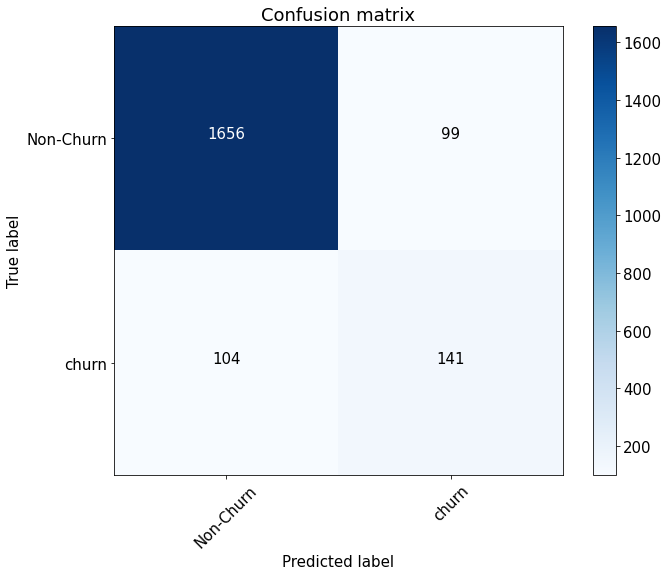

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
# mean
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_me = confusion_matrix(y_test_me, preds_mean>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_me, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_me.png")
plt.show()

Confusion matrix, without normalization
[[1686   69]
 [  72  173]]


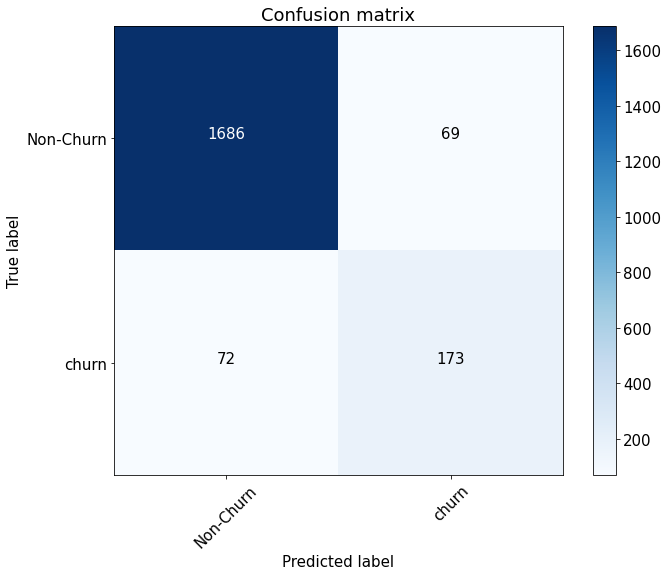

In [ ]:
# median
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_md = confusion_matrix(y_test_md, preds_median>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_md, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_md.png")
plt.show()

Confusion matrix, without normalization
[[1645  110]
 [  55  190]]


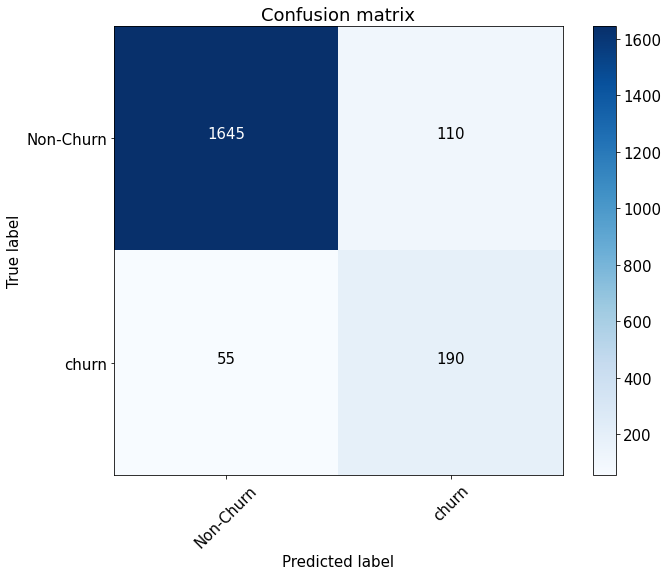

In [ ]:
# max
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_mx = confusion_matrix(y_test_mx, preds_max>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_mx, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_mx.png")
plt.show()

In [ ]:
def metrics_calculation(y_test, preds):

    roc_auc = roc_auc_score(y_test, preds)
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc

In [ ]:
all_preds = [preds_mean, preds_median, preds_max]
metrics = []
for preds in all_preds:
    best_threshold, fscore, precision, recall, roc_auc = metrics_calculation(y_test, preds)
    metrics.append([fscore, precision, recall, roc_auc])

In [ ]:
metrics_df = pd.DataFrame(np.array(metrics),
                   columns=['fscore', 'precision', 'recall', 'roc_auc'],
                   index=['preds_mean', 'preds_median', 'preds_max'])
metrics_df

,fscore,precision,recall,roc_auc
preds_mean,0.643382,0.585284,0.714286,0.934540
preds_median,0.725838,0.702290,0.751020,0.951927
preds_max,0.699634,0.634551,0.779592,0.946515
